# Exploring ensembling different sized models on uncertainty measures 

In [164]:
import pandas as pd
import numpy as np
from scipy.special import rel_entr, entr
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn2
import seaborn as sns

In [165]:
# Load data:
df18 = pd.read_csv("../exp2-inf/predictions_res18_2.csv")
df50 = pd.read_csv("../exp2-inf/predictions_res50_2.csv")
df101 = pd.read_csv("../exp2-inf/predictions_res101_2.csv")
label = pd.read_csv("../exp2-inf/labels.csv")
num_class = 257
pred = pd.DataFrame({
    "pred18": np.argmax(df18,axis=1),
    "pred50": np.argmax(df50,axis=1),
    "pred101": np.argmax(df101,axis=1),
    "target": label['target']
})
print(f"{df18.shape=}")
display(df18.head(1))
print(f"{df101.shape=}")
display(df101.head(1))
print(f"{pred.shape=}")
display(pred.head(1))

df18.shape=(6122, 257)


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
0,0.002548,0.003643,0.002167,0.006165,0.00484,0.00836,0.002376,0.010965,0.002399,0.008175,...,0.001317,0.002514,0.006182,0.004792,0.004116,0.004633,0.002666,0.001376,0.006288,0.002184


df101.shape=(6122, 257)


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
0,0.000012,0.000211,0.00002,0.000049,0.00007,0.000075,0.000084,0.000053,0.00004,0.000068,...,0.000061,0.000053,0.000035,0.000057,0.000019,0.000117,0.000091,0.000042,0.000036,0.000246


pred.shape=(6122, 4)


,pred18,pred50,pred101,target
0,24,24,24,24


In [166]:
def eval_pred(pred):
    for col in pred.columns.drop("target"):
        acc = (pred[col]==pred["target"]).mean()
        print(f"{col} has accuracy {acc}")
eval_pred(pred)

pred18 has accuracy 0.7535119242077752
pred50 has accuracy 0.8324077098987259
pred101 has accuracy 0.8694870957203529


In [167]:
acc18 = 0.7535
acc101 = 0.8695

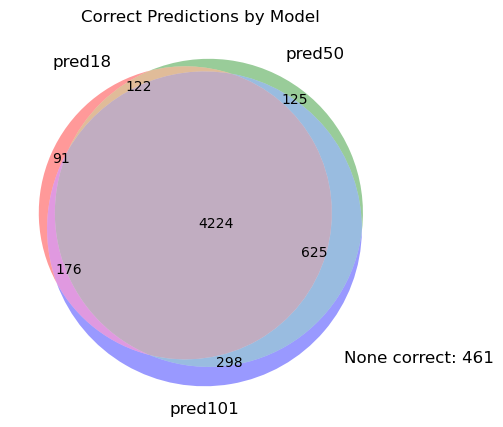

In [168]:
def venn(pred):
    # Accuracy Venn Diagram:
    df = pred
    ls = []
    total_indices = set(df.index)
    incorrect_all = total_indices
    col_names=[]
    for col in df.columns.drop("target"):
        col_names.append(col)
        cor_set = set(df[df[col] == df['target']].index)
        ls.append(cor_set)
        incorrect_all = incorrect_all - cor_set
    plt.figure(figsize=(5,5))
    if len(col_names)==2:
        venn2(ls, col_names)
    elif len(col_names)==3:
        venn3(ls, col_names)
    else:
        raise Exception("Matplotlib Venn only supports 2 or 3 sets, please subset to 3 predictions columns and target.")
    plt.title('Correct Predictions by Model')
    plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
venn(pred)

# Approach 1: Classical Voting
**Hard Voting (Plurality Voting)**: Selecting the class that receives the most votes as the final prediction. The problem with hard voting here is that we only have two models.  
**Soft Voting (Weighted Voting with uniform weights)**: Calculates the average probability of each class and then declares the winner having the highest weighted probability.  
**Weighted Voting (with validation accuracy as weights)**: Calculates weighted probability of each class based on validation accuracy, and then selecting the class with highest weighted probability

In [169]:
# Soft Voting
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    return np.argmax(sum_pred,axis=1)
pred["soft_vote"] = soft_vote(df18, df101)
display(pred.head(1))
eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote
0,24,24,24,24,24


pred18 has accuracy 0.7535119242077752
pred50 has accuracy 0.8324077098987259
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497


In [170]:
pred.head()

,pred18,pred50,pred101,target,soft_vote
0,24,24,24,24,24
1,77,77,77,77,77
2,252,252,252,252,252
3,144,144,144,144,144
4,224,224,224,224,224


In [171]:
pred["soft_vote_3"] = np.argmax(df18+df50+df101,axis=1)
pred["hard_vote_3"] = np.where((pred["pred101"] != pred["pred18"]) & (pred["pred18"] == pred["pred50"]), pred["pred50"], pred["pred101"])
eval_pred(pred)

pred18 has accuracy 0.7535119242077752
pred50 has accuracy 0.8324077098987259
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
soft_vote_3 has accuracy 0.8830447566154851
hard_vote_3 has accuracy 0.8740607644560601


In [172]:
# Weighted Soft Voting
def weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    return np.argmax(weighted_pred,axis=1)
pred["weighted_vote"] = weighted_vote(df18, df101, 0.75, 0.87)
display(pred.head(1))
eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,soft_vote_3,hard_vote_3,weighted_vote
0,24,24,24,24,24,24,24,24


pred18 has accuracy 0.7535119242077752
pred50 has accuracy 0.8324077098987259
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
soft_vote_3 has accuracy 0.8830447566154851
hard_vote_3 has accuracy 0.8740607644560601
weighted_vote has accuracy 0.873734073832081


In [173]:
def weighted_vote3(pred1, pred2, pred3, weight1, weight2, weight3):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)+np.multiply(weight3,pred3)
    return np.argmax(weighted_pred,axis=1)
pred["weighted_vote_3"] = weighted_vote3(df18, df50, df101, 0.75, 0.83, 0.87)
eval_pred(pred)

pred18 has accuracy 0.7535119242077752
pred50 has accuracy 0.8324077098987259
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
soft_vote_3 has accuracy 0.8830447566154851
hard_vote_3 has accuracy 0.8740607644560601
weighted_vote has accuracy 0.873734073832081
weighted_vote_3 has accuracy 0.882391375367527


# Approach 2: Uncertainty Voting
We propose an alternative aggregation strategy based on KL Divergence, Entropy, and Cross Entropy among the two models.

In [174]:
from scipy.special import rel_entr, entr

def calc_kl(P, Q, numclass):
    return np.sum(rel_entr(P.iloc[:, :numclass], Q.iloc[:, :numclass]), axis=1)

# Calculate Entropy
def calc_entropy(P, numclass):
    return np.sum(entr(P.iloc[:, :numclass]), axis=1)

# Calculate Cross-Entropy
def calc_cross_ent(P, Q, numclass):
    return -np.sum(P.iloc[:, :numclass] * np.log(Q.iloc[:, :numclass]), axis=1)

unc_pred = pd.DataFrame()
unc_pred["kl_18_101"] = calc_kl(df18,df101,num_class)
unc_pred["kl_101_18"] = calc_kl(df101,df18,num_class)
unc_pred["kl_18_50"] = calc_kl(df18,df50,num_class)
unc_pred["ent_18"] = calc_entropy(df18,num_class)
unc_pred["ent_50"] = calc_entropy(df18,num_class)
unc_pred["ent_101"] = calc_entropy(df101,num_class)
unc_pred["ce_18_101"] = calc_cross_ent(df18,df101,num_class)
unc_pred["ce_101_18"] = calc_cross_ent(df101,df18,num_class)

unc_pred.head()

,kl_18_101,kl_101_18,kl_18_50,ent_18,ent_50,ent_101,ce_18_101,ce_101_18
0,4.241348,3.726702,0.368930,5.372475,5.372475,0.360979,9.613823,4.087681
1,1.413814,0.609247,0.296182,3.329311,3.329311,0.519544,4.743126,1.128791
2,0.005484,0.008508,0.009008,0.077559,0.077559,0.125732,0.083042,0.134240
3,0.064559,0.032851,0.101180,0.580312,0.580312,0.176968,0.644870,0.209819
4,1.262630,0.503336,0.825940,3.061391,3.061391,0.243561,4.324021,0.746897


**Method 1** We select the prediction of the model with lower entropy (i.e. lower uncertainty) This is a flavor of hard voting, as in it is not going to predict anything that isn't already a top prediction of either model.

pred18 has accuracy 0.7535119242077752
pred50 has accuracy 0.8324077098987259
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
soft_vote_3 has accuracy 0.8830447566154851
hard_vote_3 has accuracy 0.8740607644560601
weighted_vote has accuracy 0.873734073832081
weighted_vote_3 has accuracy 0.882391375367527
min_entropy_pred has accuracy 0.8707938582162692


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


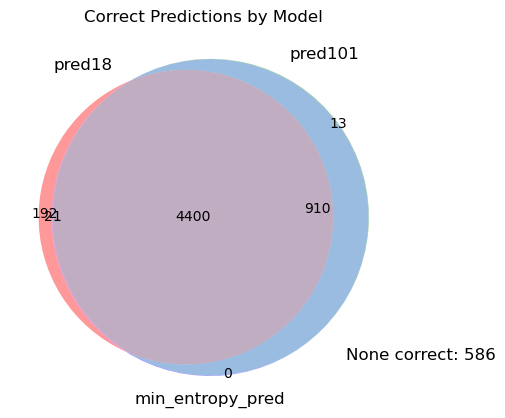

In [175]:
pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
pred.head(1)
eval_pred(pred)
venn(pred[["pred18","pred101","min_entropy_pred","target"]])

**Method 2** We combine the predictions of models by assigning the other model's entropy as weights, i.e a model receives more weights when the other models is uncertain.

In [176]:
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    return np.argmax(weighted_pred,axis=1)

def vec_weighted_vote3(pred1, pred2, pred3, weightvec1, weightvec2, weightvec3):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0) + pred3.mul(weightvec3, axis=0)
    return np.argmax(weighted_pred,axis=1)

pred["unc_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])

display(pred.head(1))
# eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,soft_vote_3,hard_vote_3,weighted_vote,weighted_vote_3,min_entropy_pred,unc_weighted_vote
0,24,24,24,24,24,24,24,24,24,24,24


In [177]:
pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
display(pred.head(1))
# eval_pred(pred)
# venn(pred[["target","pred18","pred101","kl_weighted_vote"]])

,pred18,pred50,pred101,target,soft_vote,soft_vote_3,hard_vote_3,weighted_vote,weighted_vote_3,min_entropy_pred,unc_weighted_vote,kl_weighted_vote
0,24,24,24,24,24,24,24,24,24,24,24,24


In [185]:
pred["kl_weighted_vote_3"] = vec_weighted_vote3(df18,df50, df101, unc_pred["kl_101_18"],unc_pred["kl_18_50"], unc_pred["kl_18_101"])
pred["ent_weighted_vote_3"] = vec_weighted_vote3(df18,df50, df101, unc_pred["ent_101"],unc_pred["ent_50"], unc_pred["ent_18"])
eval_pred(pred)

pred18 has accuracy 0.7535119242077752
pred50 has accuracy 0.8324077098987259
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
soft_vote_3 has accuracy 0.8830447566154851
hard_vote_3 has accuracy 0.8740607644560601
weighted_vote has accuracy 0.873734073832081
weighted_vote_3 has accuracy 0.882391375367527
min_entropy_pred has accuracy 0.8707938582162692
unc_weighted_vote has accuracy 0.8727540019601437
kl_weighted_vote has accuracy 0.8753675269519765
kl_weighted_vote_3 has accuracy 0.8805945769356419
ce_weighted_vote has accuracy 0.873734073832081
kl_sqr_weighted_vote has accuracy 0.875530872263966
kl_acc_weighted_vote has accuracy 0.8756942175759556
ent_kl_weighted_vote has accuracy 0.8738974191440706
ent_weighted_vote_3 has accuracy 0.8819013394315584


In [179]:
pred["ce_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
display(pred.head(1))
# eval_pred(pred)
# venn(pred[["target","pred18","pred101","kl_weighted_vote"]])

,pred18,pred50,pred101,target,soft_vote,soft_vote_3,hard_vote_3,weighted_vote,weighted_vote_3,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,kl_weighted_vote_3,ce_weighted_vote
0,24,24,24,24,24,24,24,24,24,24,24,24,24,24


In [180]:
pred["kl_sqr_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
display(pred.head(1))
# eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,soft_vote_3,hard_vote_3,weighted_vote,weighted_vote_3,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,kl_weighted_vote_3,ce_weighted_vote,kl_sqr_weighted_vote
0,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24


In [181]:
pred["kl_acc_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**acc18, unc_pred["kl_18_101"]**acc101)
display(pred.head(1))
# eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,soft_vote_3,hard_vote_3,weighted_vote,weighted_vote_3,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,kl_weighted_vote_3,ce_weighted_vote,kl_sqr_weighted_vote,kl_acc_weighted_vote
0,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24


In [182]:
pred["ent_kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
display(pred.head(1))

,pred18,pred50,pred101,target,soft_vote,soft_vote_3,hard_vote_3,weighted_vote,weighted_vote_3,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,kl_weighted_vote_3,ce_weighted_vote,kl_sqr_weighted_vote,kl_acc_weighted_vote,ent_kl_weighted_vote
0,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24


In [139]:
pred["kl_ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**unc_pred["ent_101"], unc_pred["kl_18_101"]**unc_pred["ent_18"])
display(pred.head(1))
eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,soft_vote_3,hard_vote_3,weighted_vote,weighted_vote_3,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,kl_weighted_vote_3,ce_weighted_vote,kl_sqr_weighted_vote,kl_acc_weighted_vote,ent_kl_weighted_vote,kl_ent_weighted_vote
0,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24


pred18 has accuracy 0.7535119242077752
pred50 has accuracy 0.8324077098987259
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
soft_vote_3 has accuracy 0.8830447566154851
hard_vote_3 has accuracy 0.8740607644560601
weighted_vote has accuracy 0.873734073832081
weighted_vote_3 has accuracy 0.882391375367527
min_entropy_pred has accuracy 0.8707938582162692
unc_weighted_vote has accuracy 0.8727540019601437
kl_weighted_vote has accuracy 0.8753675269519765
kl_weighted_vote_3 has accuracy 0.83453119895459
ce_weighted_vote has accuracy 0.873734073832081
kl_sqr_weighted_vote has accuracy 0.875530872263966
kl_acc_weighted_vote has accuracy 0.8756942175759556
ent_kl_weighted_vote has accuracy 0.8738974191440706
kl_ent_weighted_vote has accuracy 0.8740607644560601


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


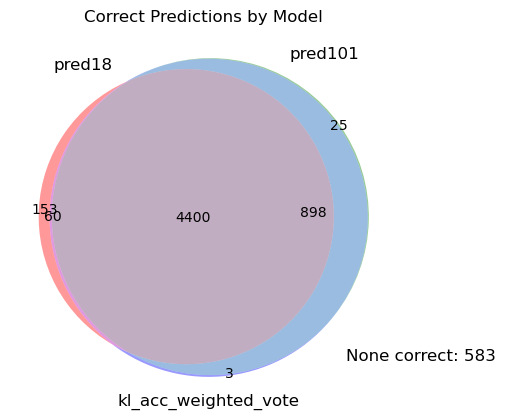

In [140]:
venn(pred[["target","pred18","pred101","kl_acc_weighted_vote"]])

In [141]:
unc_pred.head()

,kl_18_101,kl_101_18,kl_50_18,ent_18,ent_50,ent_101,ce_18_101,ce_101_18
0,4.241348,3.726702,0.457211,5.372475,5.372475,0.360979,9.613823,4.087681
1,1.413814,0.609247,0.264720,3.329311,3.329311,0.519544,4.743126,1.128791
2,0.005484,0.008508,0.017128,0.077559,0.077559,0.125732,0.083042,0.134240
3,0.064559,0.032851,0.044216,0.580312,0.580312,0.176968,0.644870,0.209819
4,1.262630,0.503336,0.973988,3.061391,3.061391,0.243561,4.324021,0.746897


In [142]:
def calc_tpr(targ, pred):
    tp = np.sum((targ == 1) & (pred == 1))
    fn = np.sum((targ == 1) & (pred == 0))
    return tp / (tp + fn)
def calc_fpr(targ, pred):
    fp = np.sum((targ == 0) & (pred == 1))
    tn = np.sum((targ == 0) & (pred == 0))
    return fp / (fp + tn)
def predict_correctness(ent_ls,threshold):
    return np.where(ent_ls>threshold,0,1)

max_ent=5.4707640691693005||min_ent=0.0012443204783566303


,pred18,target,ent_18,cor_18
0,24,24,5.372475,1
1,77,77,3.329311,1


<Axes: >

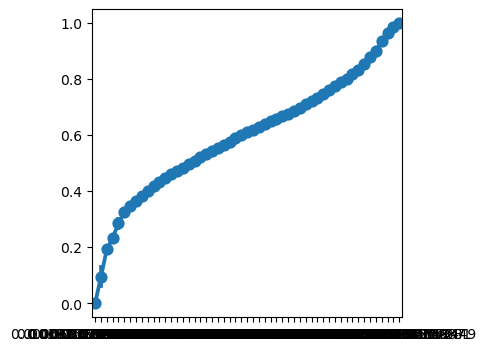

In [143]:
prep_roc18 = pred[["pred18", "target"]].copy()
prep_roc18["ent_18"] = unc_pred["ent_18"]
prep_roc18["cor_18"] = np.where(prep_roc18["pred18"]==prep_roc18["target"],1,0)
max_ent = prep_roc18["ent_18"].max()
min_ent = prep_roc18["ent_18"].min()
print(f"{max_ent=}||{min_ent=}")
display(prep_roc18.head(2))
tpr = np.array([])
fpr=np.array([])
for ent_step in np.arange(min_ent,max_ent,0.1):
    temp = predict_correctness(prep_roc18["ent_18"],ent_step)
    tpr= np.append(tpr,calc_tpr(prep_roc18["cor_18"],temp))
    fpr= np.append(fpr, calc_fpr(prep_roc18["cor_18"],temp))
plt.figure(figsize=(4,4))
sns.pointplot(x=fpr,y=tpr)

max_ent=5.354127645330788||min_ent=0.0003551088551720373


,pred101,target,ent_101,cor_101
0,24,24,0.360979,1
1,77,77,0.519544,1


<Axes: >

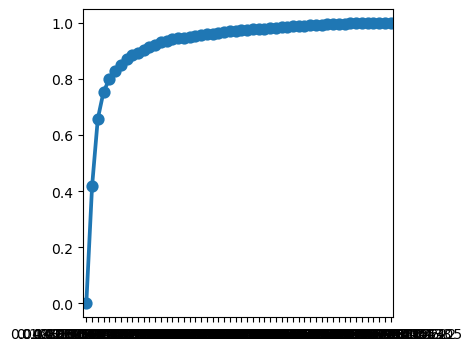

In [144]:
prep_roc101 = pred[["pred101", "target"]].copy()
prep_roc101["ent_101"] = unc_pred["ent_101"]
prep_roc101["cor_101"] = np.where(prep_roc101["pred101"]==prep_roc101["target"],1,0)
max_ent = prep_roc101["ent_101"].max()
min_ent = prep_roc101["ent_101"].min()
print(f"{max_ent=}||{min_ent=}")
display(prep_roc101.head(2))
tpr = np.array([]) 
fpr=np.array([])
for ent_step in np.arange(min_ent,max_ent,0.1):
    temp = predict_correctness(prep_roc101["ent_101"],ent_step)
    tpr= np.append(tpr,calc_tpr(prep_roc101["cor_101"],temp))
    fpr= np.append(fpr, calc_fpr(prep_roc101["cor_101"],temp))
plt.figure(figsize=(4,4))
sns.pointplot(x=fpr,y=tpr)

In [145]:
# roc = pd.DataFrame({
#     "fpr":fpr,
#     "tpr":tpr
# })
# epsilon = 0.001
# roc["tpr_over_fpr"] = (1-roc["tpr"])*(roc["fpr"]+epsilon)
# display(roc.head(2))
# # best_threshold = np.arange(min_ent,max_ent,0.1)[np.argmin(roc["tpr_over_fpr"])]
# best_threshold = 4
# print(f"{best_threshold=}")
# pred["entropy101_maxroc_vote"] = np.where(unc_pred["ent_101"]<=best_threshold, pred["pred101"],pred["pred18"])
# display(pred.head(1))
# eval_pred(pred)
# venn(pred[["target","pred18","pred101","entropy101_maxroc_vote"]])

max_ent=8.696957489755945||min_ent=0.00077365487509927


,pred101,target,kl_101_18,cor_101
0,24,24,3.726702,1
1,77,77,0.609247,1


<Axes: >

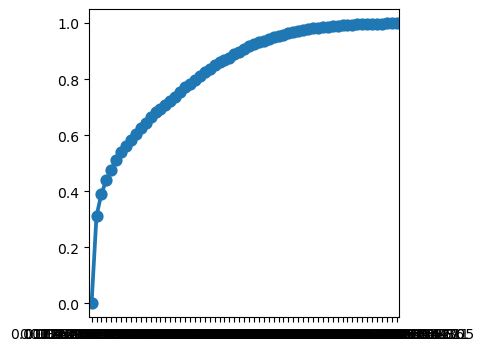

In [146]:
prep_roc101 = pred[["pred101", "target"]].copy()
prep_roc101["kl_101_18"] = unc_pred["kl_101_18"]
prep_roc101["cor_101"] = np.where(prep_roc101["pred101"]==prep_roc101["target"],1,0)
max_ent = prep_roc101["kl_101_18"].max()
min_ent = prep_roc101["kl_101_18"].min()
print(f"{max_ent=}||{min_ent=}")
display(prep_roc101.head(2))
tpr = np.array([]) 
fpr=np.array([])
for ent_step in np.arange(min_ent,max_ent,0.1):
    temp = predict_correctness(prep_roc101["kl_101_18"],ent_step)
    tpr= np.append(tpr,calc_tpr(prep_roc101["cor_101"],temp))
    fpr= np.append(fpr, calc_fpr(prep_roc101["cor_101"],temp))
plt.figure(figsize=(4,4))
sns.pointplot(x=fpr,y=tpr)

max_ent=10.509523404185035||min_ent=0.0012171367371047103


,pred101,target,kl_18_101,cor_101
0,24,24,4.241348,1
1,77,77,1.413814,1


<Axes: >

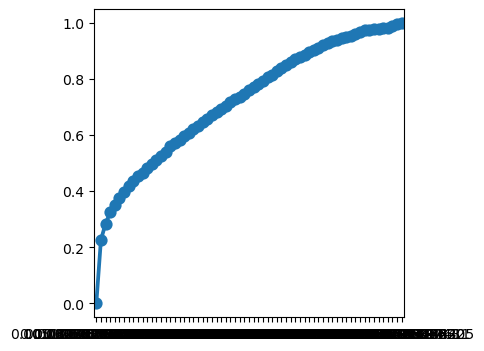

In [147]:
prep_roc101 = pred[["pred101", "target"]].copy()
prep_roc101["kl_18_101"] = unc_pred["kl_18_101"]
prep_roc101["cor_101"] = np.where(prep_roc101["pred101"]==prep_roc101["target"],1,0)
max_ent = prep_roc101["kl_18_101"].max()
min_ent = prep_roc101["kl_18_101"].min()
print(f"{max_ent=}||{min_ent=}")
display(prep_roc101.head(2))
tpr = np.array([]) 
fpr=np.array([])
for ent_step in np.arange(min_ent,max_ent,0.1):
    temp = predict_correctness(prep_roc101["kl_18_101"],ent_step)
    tpr= np.append(tpr,calc_tpr(prep_roc101["cor_101"],temp))
    fpr= np.append(fpr, calc_fpr(prep_roc101["cor_101"],temp))
plt.figure(figsize=(4,4))
sns.pointplot(x=fpr,y=tpr)